<a href="https://colab.research.google.com/github/jiananwu72/Defect-Detection/blob/main/AtomAIDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source
!pip install -q pyNSID sidpy SciFiReaders wget
!pip install numpy==1.26.4

  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-0on07w_q
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/atomai /tmp/pip-req-build-0on07w_q
  Resolved https://github.com/pycroscopy/atomai to commit 8db3e944cd9ece68c33c8e3fcca3ef3ce9a111ea
  Preparing metadata (setup.py) ... done


In [5]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt

In [6]:
download_link1 = 'https://drive.google.com/uc?id=1-4-IQ71m--OelQb1891GnbG1Ako1-DKh'
download_link2 = 'https://drive.google.com/uc?id=18JK9GcMPMWHmHtwArujVQRLr6N4VIM_j'
!gdown -q $download_link1 -O 'training_data.npy'
!gdown -q $download_link2 -O 'validation_data.npy'

# Load train/test data (this is a simple dataset generated just from a single image)
dataset = np.load('training_data.npy')
images = dataset['X_train']
labels = dataset['y_train']
images_test = dataset['X_test']
labels_test = dataset['y_test']
# Load validation data (data from different experiment)
# expdata = np.load("validation_data.npy")

In [7]:
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(1656, 1, 256, 256) (1656, 256, 256)
(414, 1, 256, 256) (414, 256, 256)


##Training Data

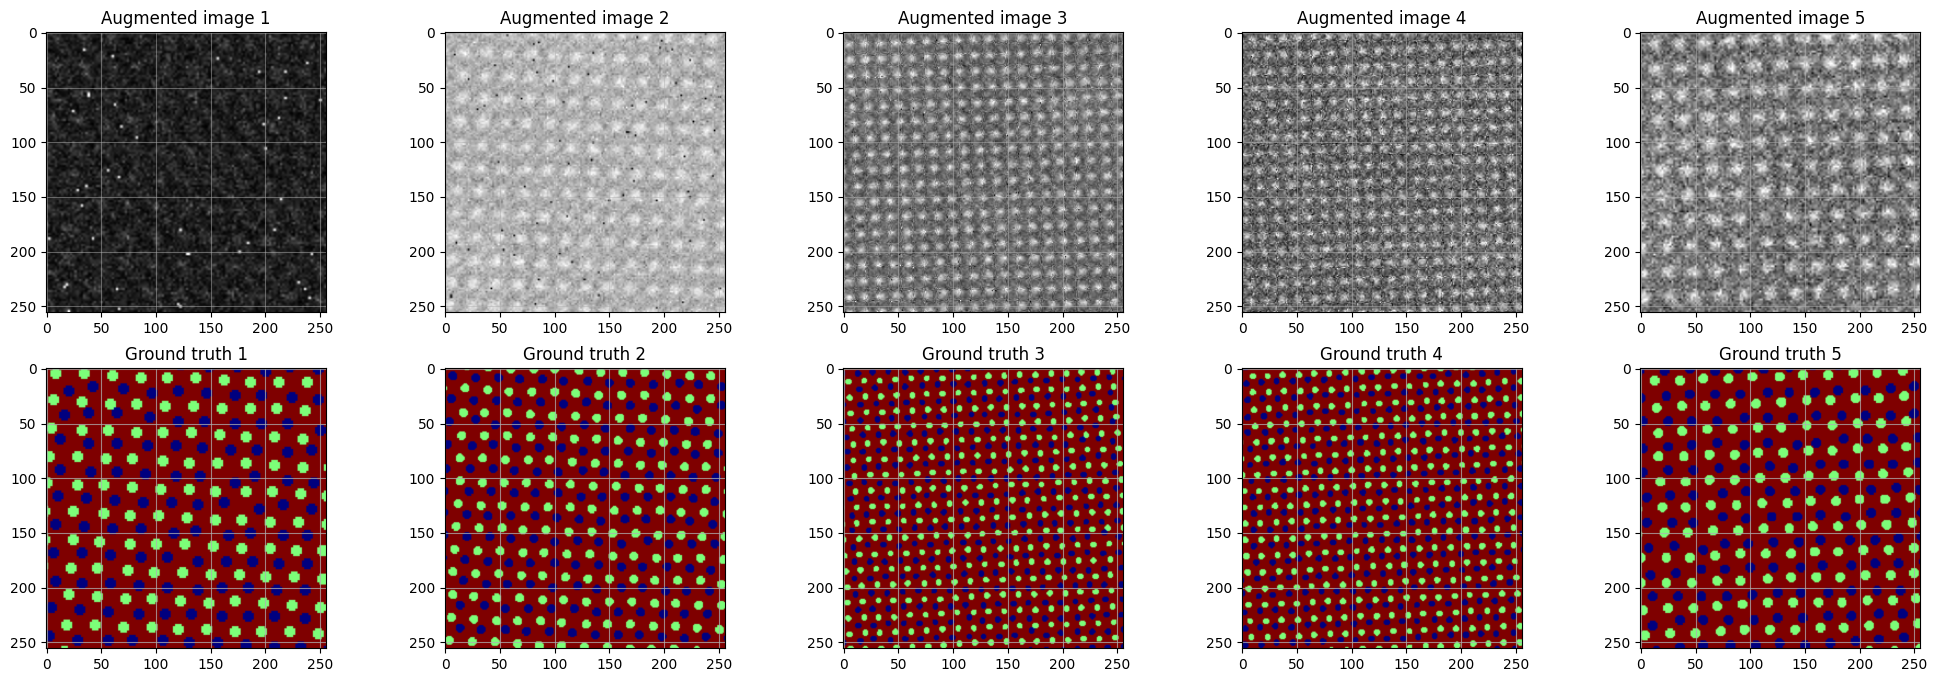

In [8]:
n = 5 # number of images to plot
k = 0 #starting point

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i+k-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i+k))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i+k-1], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i+k))
    ax.grid(alpha=0.75)

In [9]:
model = aoi.models.Segmentor(nb_classes=3)
print(model.net)

Epoch 1/300 ... Training loss: 1.2846 ... Test loss: 1.2103 ... Train Accuracy: 0.0901 ... Test Accuracy: 0.0405 ... GPU memory usage: 6172/15360
Epoch 100/300 ... Training loss: 0.4629 ... Test loss: 0.3874 ... Train Accuracy: 0.6647 ... Test Accuracy: 0.6693 ... GPU memory usage: 7038/15360
Epoch 200/300 ... Training loss: 0.28 ... Test loss: 0.2447 ... Train Accuracy: 0.7247 ... Test Accuracy: 0.7444 ... GPU memory usage: 7038/15360
Epoch 300/300 ... Training loss: 0.2372 ... Test loss: 0.2271 ... Train Accuracy: 0.738 ... Test Accuracy: 0.7388 ... GPU memory usage: 7038/15360
Model (final state) evaluation loss: 0.2386
Model (final state) accuracy: 0.7213
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.2329
Model (final state) accuracy: 0.732
Plotting training history


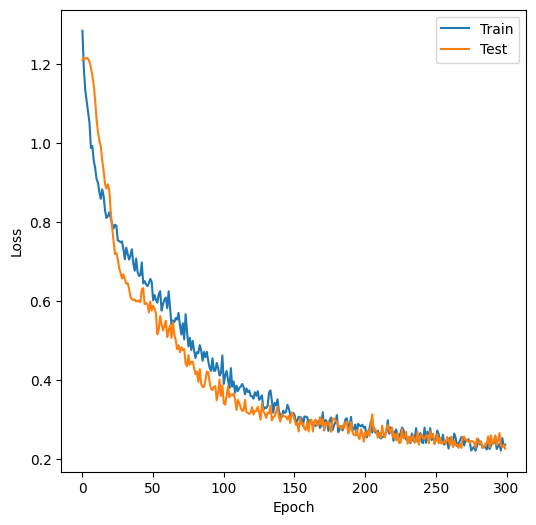

In [11]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True # training parameters
)

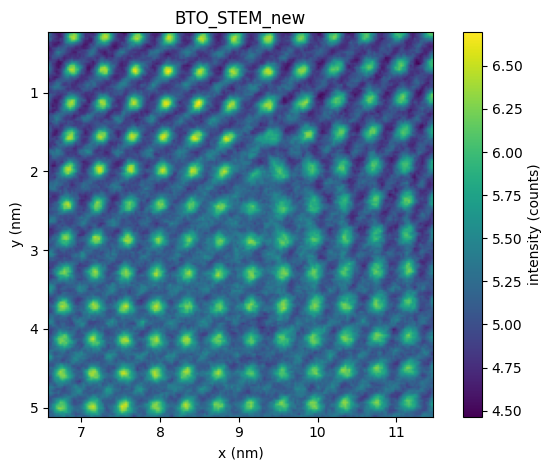

In [38]:
import wget
import SciFiReaders as sr
wget.download(url='https://zenodo.org/record/8190744/files/bto_atomic.dm3?download=1',
              out = 'bto_atomic.dm3')

dm3_file = r'bto_atomic.dm3'
dm3_reader = sr.DM3Reader(dm3_file)
dataset = dm3_reader.read()["Channel_000"]
dataset.title = 'BTO_STEM'
dataset._axes[0].quantity = 'x'
dataset._axes[1].quantity = 'y'
# dataset = dataset[700:900,150:350]

dataset = dataset[270:470,10:210]
expdata = np.array(dataset)
dataset.plot();

In [39]:
nn_output, coordinates = model.predict(expdata)

Batch 1/1
1 image was decoded in approximately 0.0108 seconds


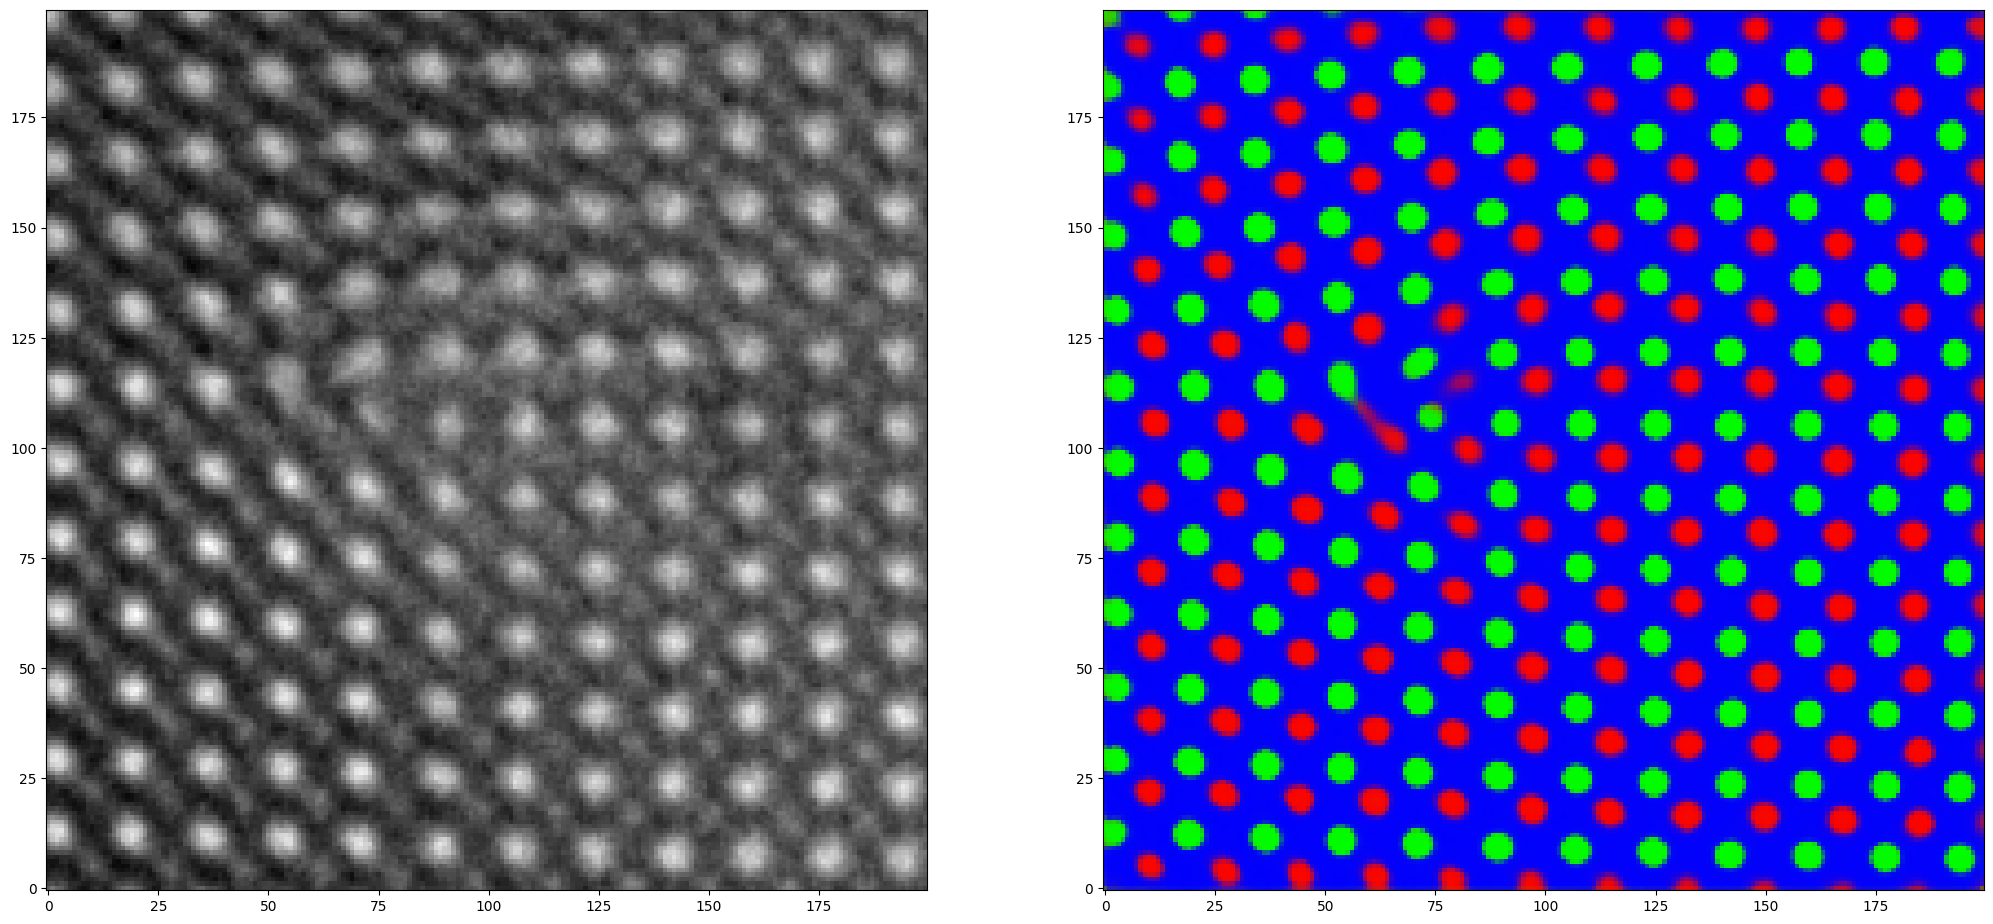

In [40]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

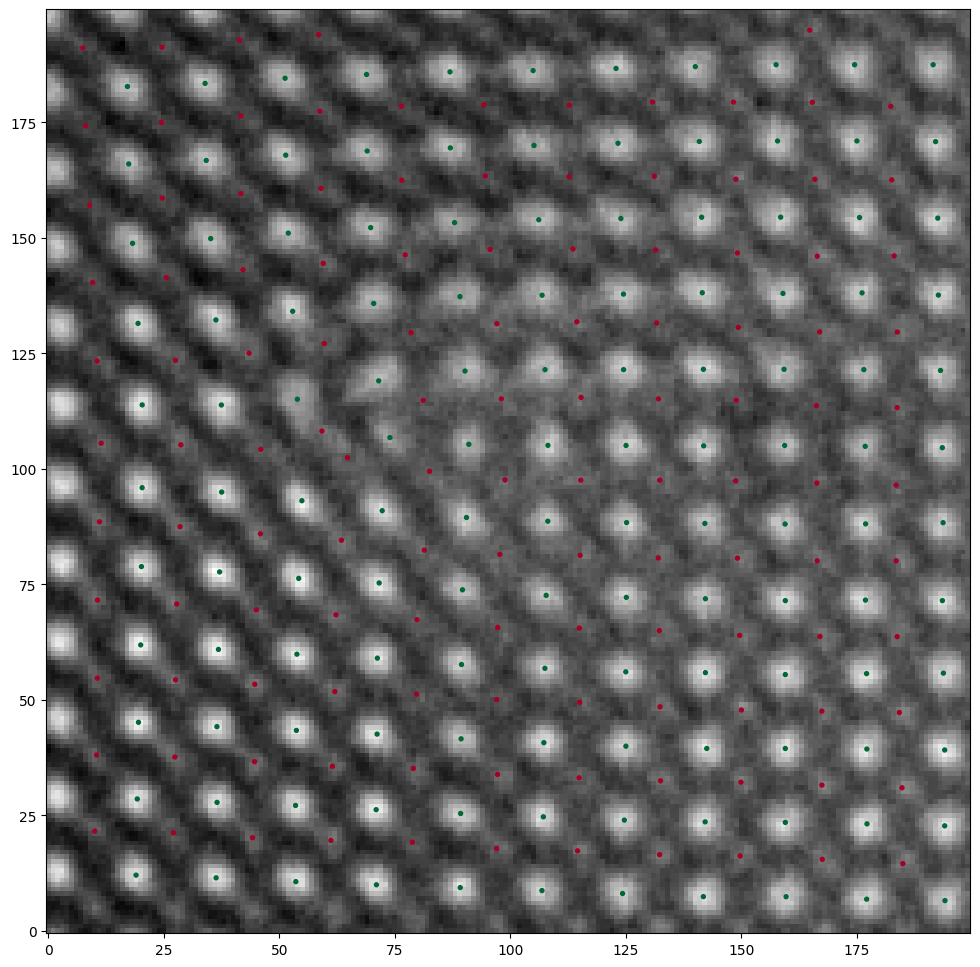

In [15]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

##PCA

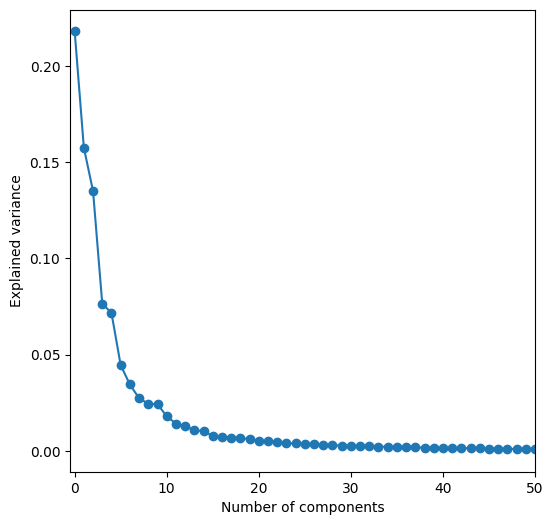

In [16]:
imstack = aoi.stat.imlocal(nn_output, coordinates, window_size=32, coord_class=1)
imstack.pca_scree_plot(plot_results=True);

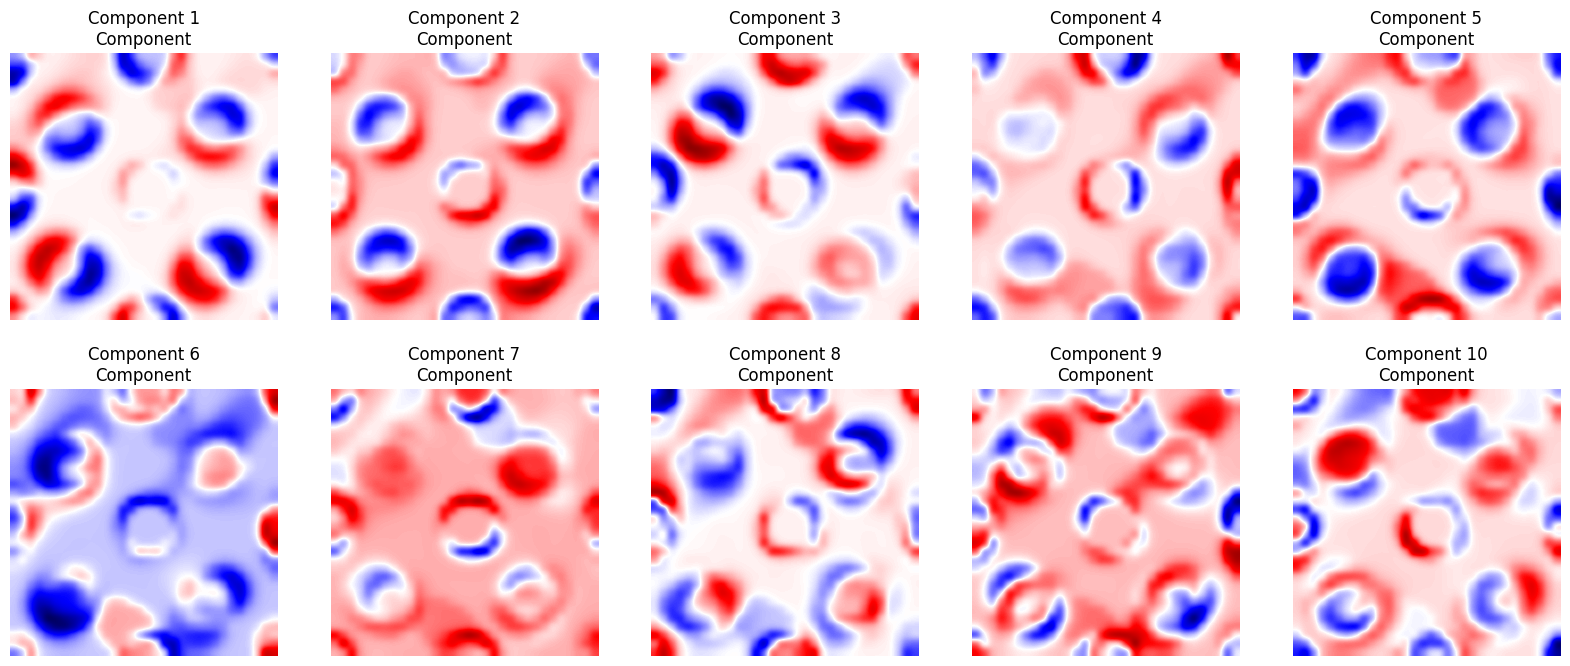

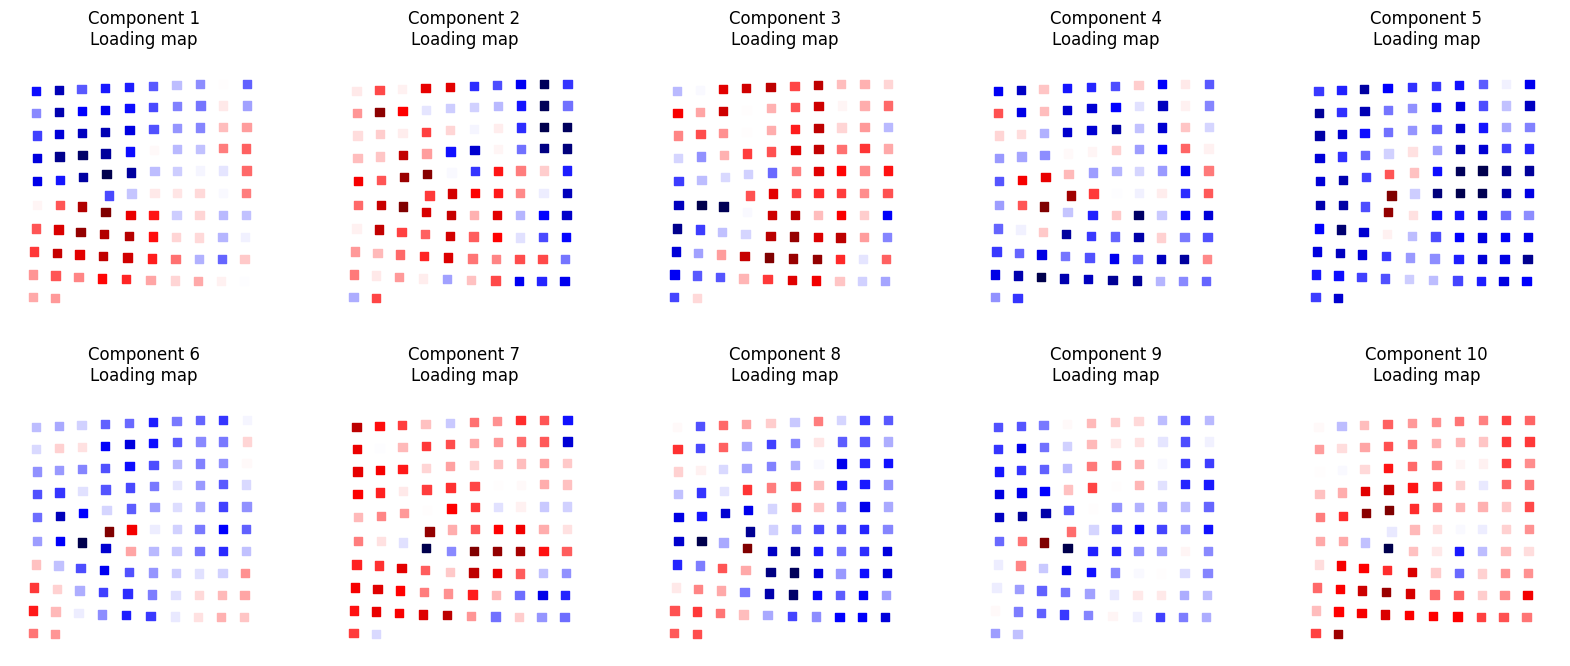

In [17]:
pca_results = imstack.imblock_pca(10, plot_results=True)

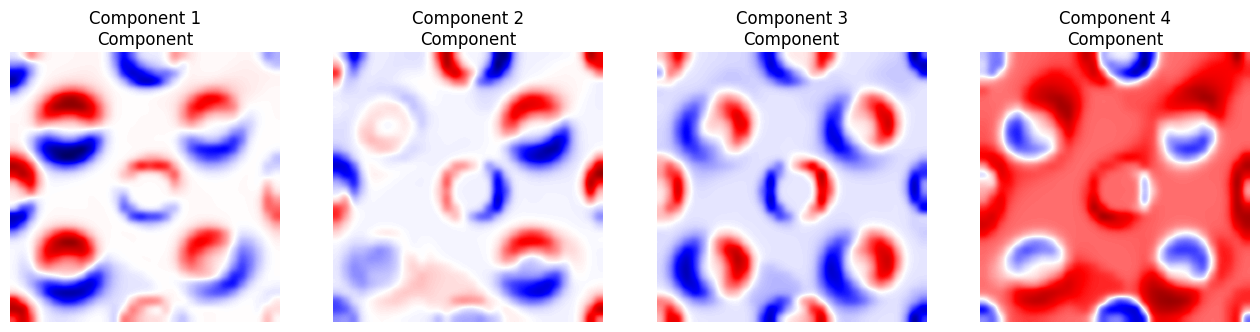

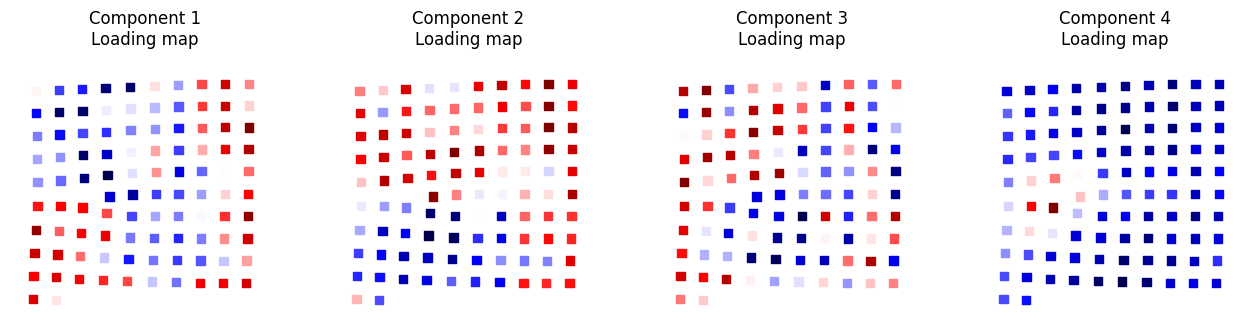

In [19]:
ica_results = imstack.imblock_ica(4, plot_results=True)

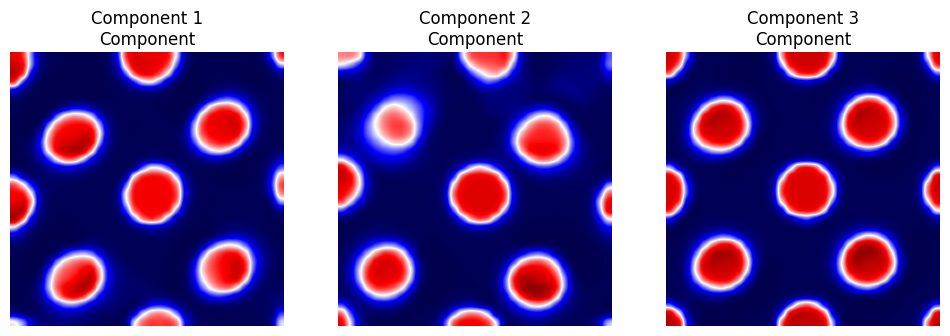

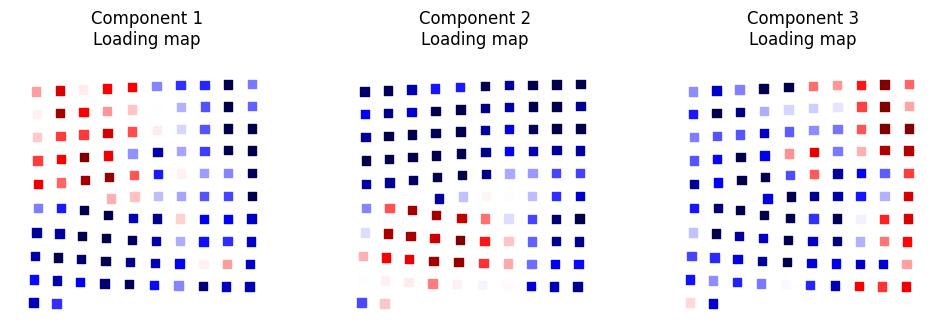

In [64]:
nmf_results = imstack.imblock_nmf(3, plot_results=True)

##Training Dataset Generation

In [103]:
from atomai.utils import create_lattice_mask, extract_patches_
from atomai.transforms import datatransform
import numpy as np
import matplotlib.pyplot as plt

In [104]:
download_link = 'https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz'
!gdown $download_link -O 'img_w_coord.npy'
img_w_coord = np.load('img_w_coord.npy')
lattice_im = img_w_coord['lattice_img']
xy_atoms_a = img_w_coord['lattice_coord_a']
xy_atoms_b = img_w_coord['lattice_coord_b']
print(lattice_im.shape, xy_atoms_a.shape, xy_atoms_b.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz
From (redirected): https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz&confirm=t&uuid=18593e31-1333-493c-95ac-39977521f727
To: /content/img_w_coord.npy
100% 118M/118M [00:01<00:00, 80.6MB/s]
(3801, 3801) (2, 64932) (2, 65465)


In [105]:
lattice_mask_a = create_lattice_mask(lattice_im, xy_atoms_a.T)
lattice_mask_b = create_lattice_mask(lattice_im, xy_atoms_b.T)

multiclass = True

if multiclass:
    lattice_mask_backgr = 1 - (lattice_mask_a + lattice_mask_b)
    lattice_mask = np.concatenate(
        (lattice_mask_a[..., None],
         lattice_mask_b[..., None],
         lattice_mask_backgr[..., None]), # we need to add a background class
        axis=-1)
else:
    lattice_mask = lattice_mask_a + lattice_mask_b
    lattice_mask[lattice_mask>1] = 1

In [141]:
images_all, labels_all = extract_patches_(
    lattice_im, lattice_mask, patch_size=200, num_patches=999, random_state=42)
print(images_all.shape, labels_all.shape)

(999, 200, 200) (999, 200, 200, 3)


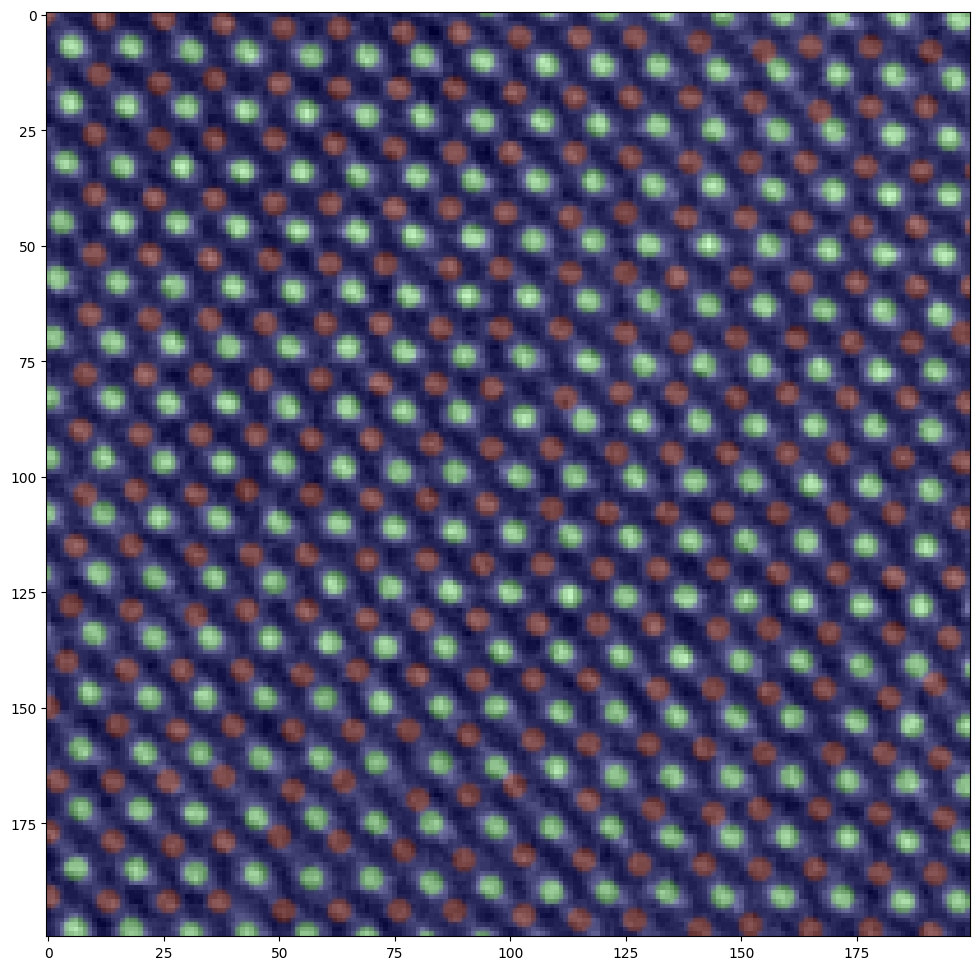

In [143]:
k = 101
plt.figure(figsize=(12, 12), dpi=100)
plt.imshow(images_all[k], cmap='gray')
plt.imshow(labels_all[k], alpha=.2, interpolation='Gaussian')

In [145]:
labels_all = np.concatenate([labels_all, nn_output], axis=0)
loc = aoi.predictors.Locator()
coord = loc.run(labels_all)

##VAE

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import atomai as aoi

In [149]:
window_size = 24
s = aoi.stat.imlocal(
    np.sum(labels_all[..., :-1], -1)[..., None], # convert to a single channel (no background)
    coord, window_size, 0)


GMM components


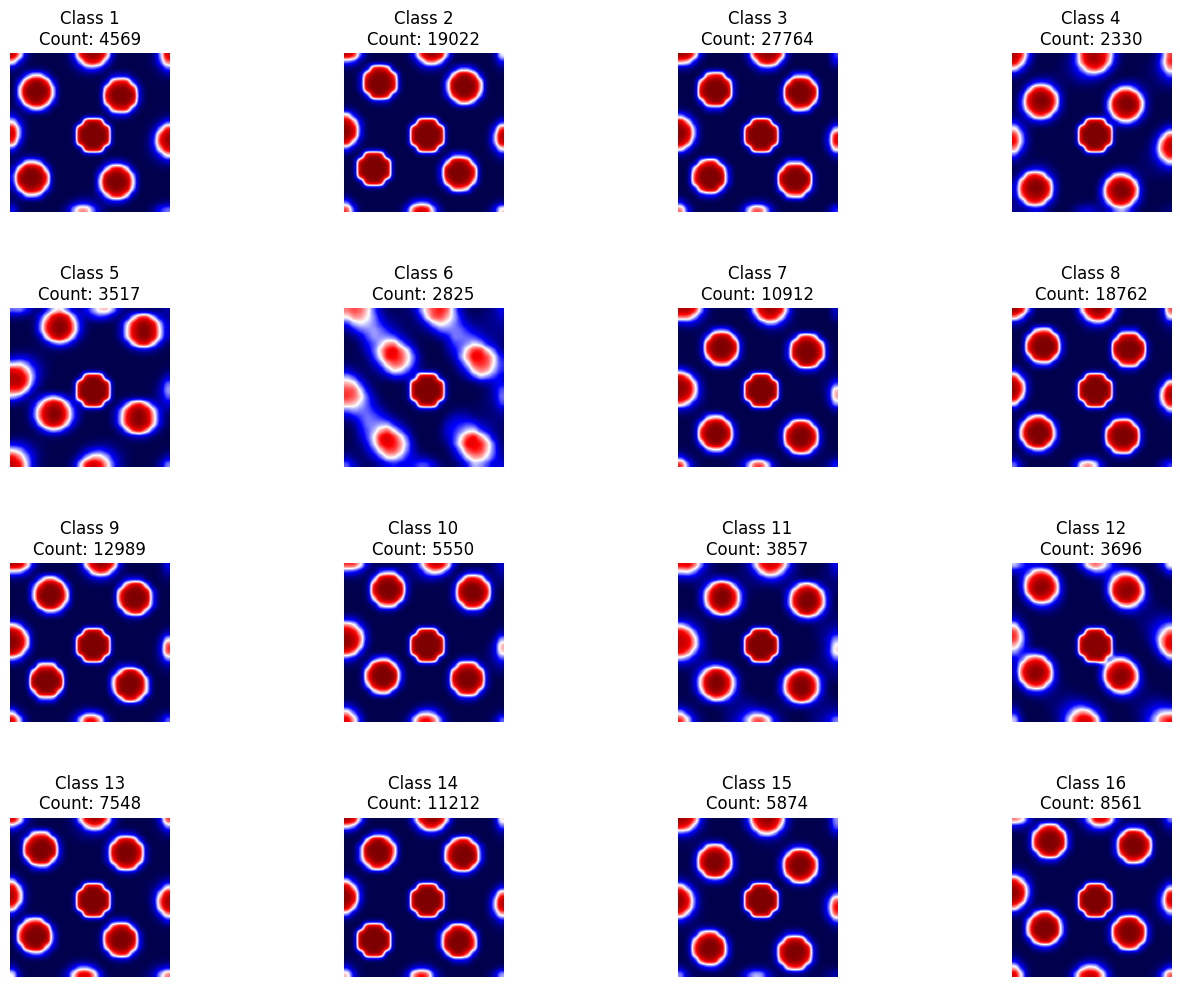

In [150]:
s.gmm(n_components=16, plot_results=True, random_state=42);

In [151]:
imstack = s.imgstack[..., 0] # will be used as training/test data
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

from sklearn.model_selection import train_test_split
imstack_train, imstack_test = train_test_split(
    imstack, test_size=0.15, shuffle=True, random_state=0)
print(imstack_train.shape, imstack_test.shape)

(126639, 24, 24) (22349, 24, 24)


In [152]:
# Ititialize model
in_dim = (window_size, window_size)
vae = aoi.models.VAE(in_dim)
# Train
vae.fit(X_train=imstack_train, X_test=imstack_test, training_cycles=200, batch_size=200)

Epoch: 1/200, Training loss: 25.8628, Test loss: 18.4032
Epoch: 2/200, Training loss: 17.5670, Test loss: 16.9444
Epoch: 3/200, Training loss: 16.4607, Test loss: 16.2071
Epoch: 4/200, Training loss: 15.9337, Test loss: 15.8082
Epoch: 5/200, Training loss: 15.6030, Test loss: 15.5526
Epoch: 6/200, Training loss: 15.3788, Test loss: 15.3338
Epoch: 7/200, Training loss: 15.1948, Test loss: 15.1616
Epoch: 8/200, Training loss: 15.0494, Test loss: 15.0279
Epoch: 9/200, Training loss: 14.9284, Test loss: 14.9049
Epoch: 10/200, Training loss: 14.8181, Test loss: 14.7989
Epoch: 11/200, Training loss: 14.7196, Test loss: 14.7244
Epoch: 12/200, Training loss: 14.6398, Test loss: 14.6293
Epoch: 13/200, Training loss: 14.5654, Test loss: 14.5657
Epoch: 14/200, Training loss: 14.5089, Test loss: 14.5469
Epoch: 15/200, Training loss: 14.4582, Test loss: 14.4745
Epoch: 16/200, Training loss: 14.4035, Test loss: 14.4310
Epoch: 17/200, Training loss: 14.3688, Test loss: 14.3965
Epoch: 18/200, Training

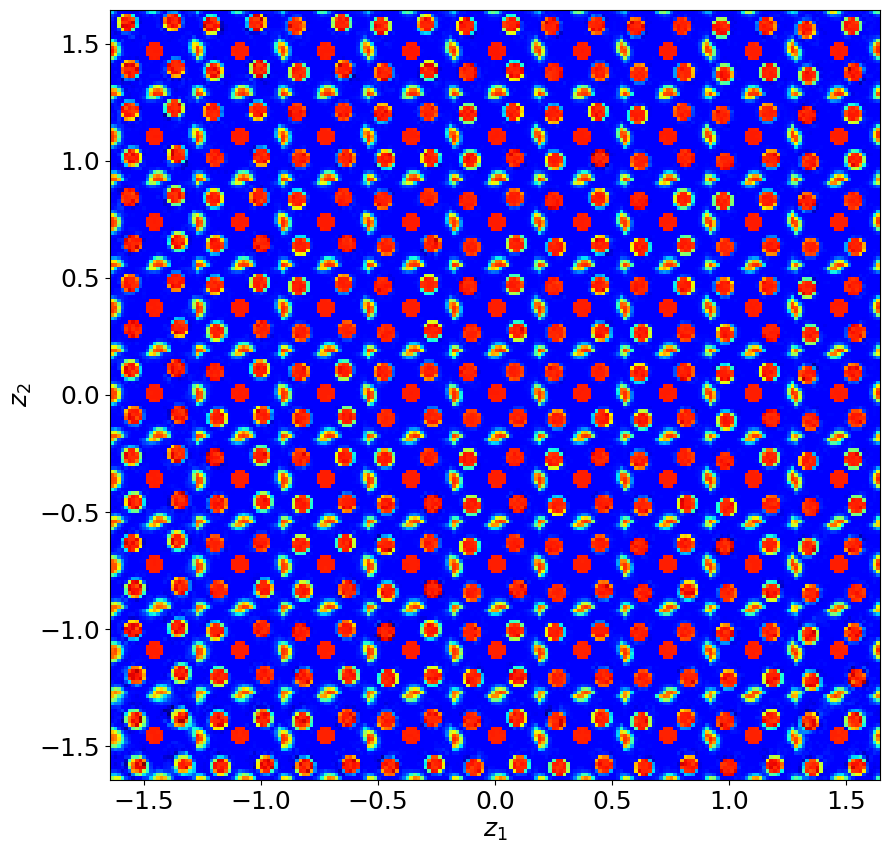

In [164]:
vae.manifold2d(cmap="jet");

In [155]:
z_mean, z_sd = vae.encode(imstack)
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

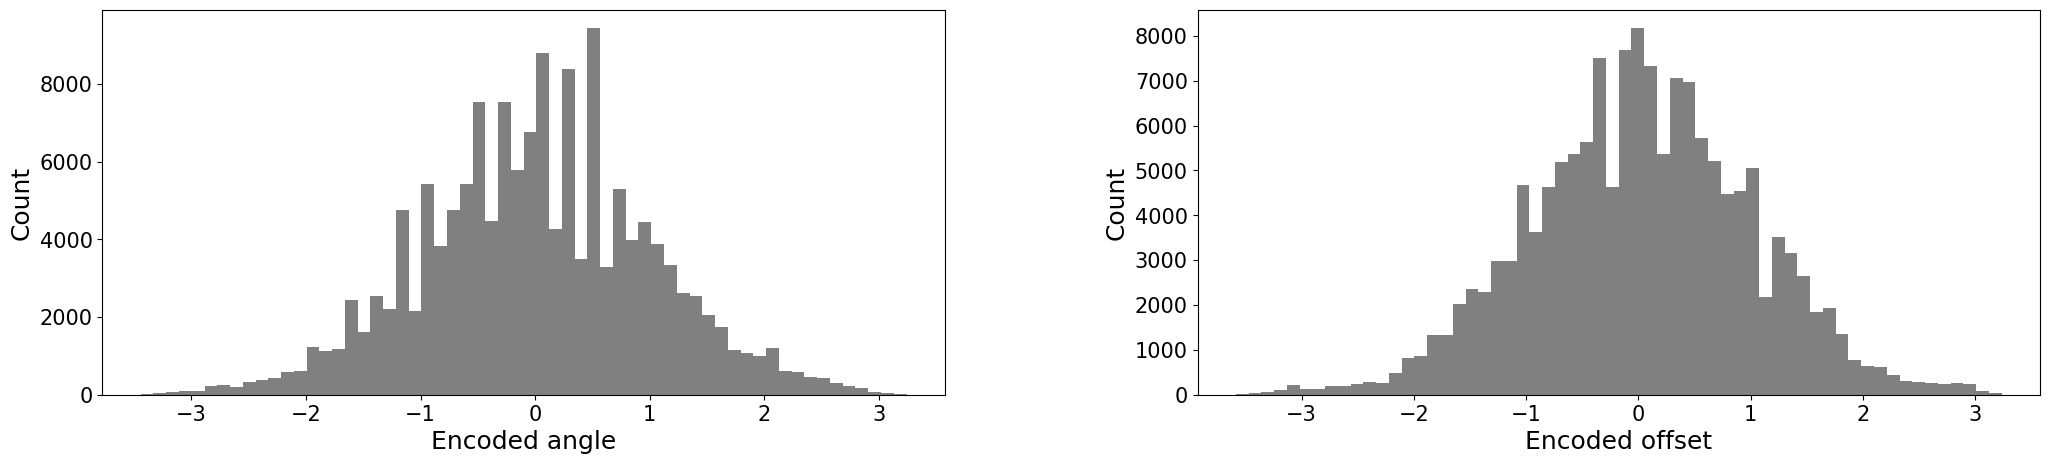

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='gray')
ax[1].hist(z2[:, 0], bins=60, color='gray')
ax[0].set_xlabel("Encoded angle", fontsize=18)
ax[1].set_xlabel("Encoded offset", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

In [159]:
frame = 49 # select frame

com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = lattice_coord[frame] # get Si coordinates for plotting
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(STEM_real[frame,...,0], cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet", vmin=col_min0, vmax=col_max0)
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(STEM_real[frame,...,0], cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(STEM_real[frame,...,0], cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()

IndexError: index 0 is out of bounds for axis 1 with size 0